## <center>Title: Case Study 1<center>
## <center>Author: Paolo Ferrari<center>
## <center>Date: 2023-03-29<center>
    
---

### 1. Introduction

In this Case Study, we analyze the grades of multiple assignments in four semesters of the UIUC Course Stat 452. 

The goal here is to predict the grades of the second exam of the course as a function of the grades of other assignments and also of the semester of the course.  

To achieve that, we test multiple linear regression models with different numbers of predictors. We then use different metrics to test the models and select the best one. 

Finally, we conclude by analyzing the performance of the selected model against the real data.

So, let's get started!

---

In [1]:
## Importing the libraries

library(repr)
library(ggplot2)

Warning message:
"package 'repr' was built under R version 4.2.3"


### 2. Data Overview


We first read the data from CSV file

In [2]:
data = read.csv("grades.csv")

Let's then take a short view of the dataset

In [3]:
head(data)

,exam2,exam1,project,cs,hw,participation,semester
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,100.00,100.00,100,95.24,98.84,95.77,1
2,97.33,100.00,100,100.00,98.22,93.87,1
3,100.00,98.82,100,100.00,94.37,95.38,1
4,97.33,97.06,100,95.24,98.35,96.85,1
5,92.00,97.06,98,95.24,94.43,84.82,1
6,97.33,89.41,90,97.62,95.80,89.33,1


In this dataset, the target variable y is the column Exam2 and all other columns are the predictors X. **Regarding the predictors, we treat all the 6 variables as numerical type for simplicity.**

To visualize the dependency between X and y, we will make 5 different scatterplots for each pair formed by y and a predictor excluding the semester number. We also include the regression line for each predictor variable to visualize the overall trends.

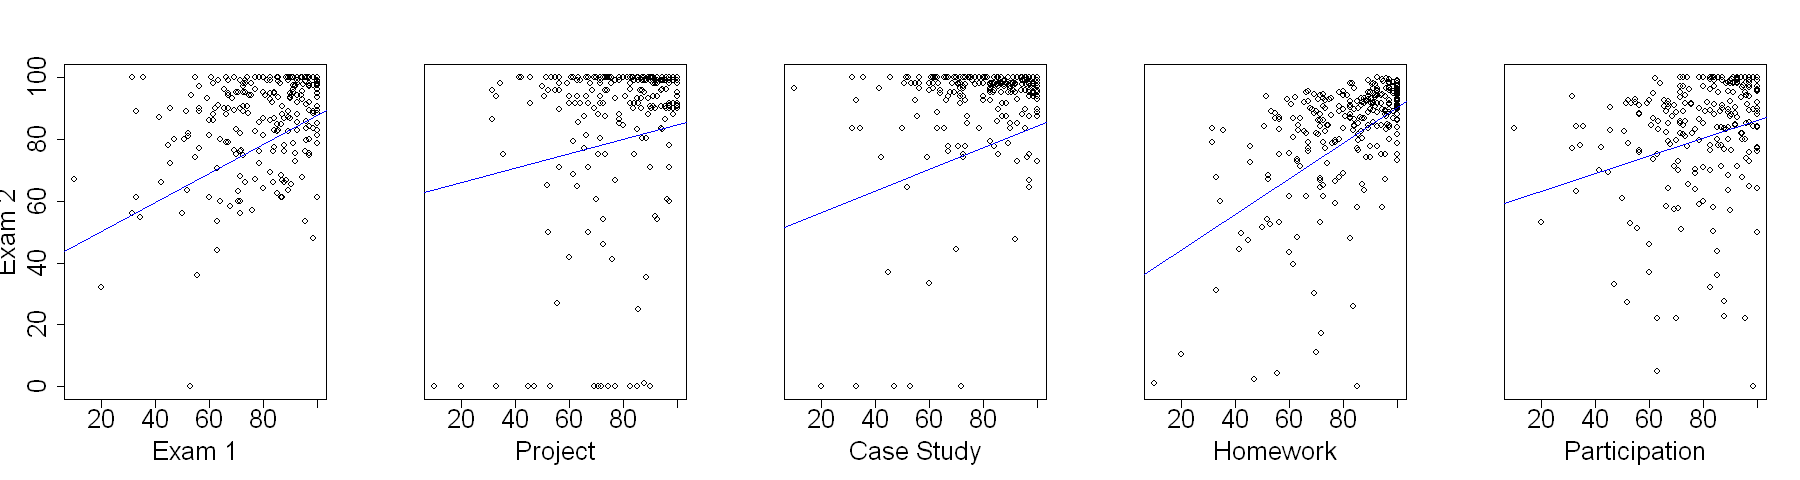

In [4]:
layout(matrix(c(1,2,3,4,5), nrow = 1, ncol = 5, byrow = TRUE))
options(repr.plot.width=15, repr.plot.height=4)
plot(data$exam2, data$exam1,xlab = "Exam 1", ylab = "Exam 2",cex.lab=2, cex.axis = 2)
abline(lm(data$exam2 ~data$exam1), col="blue")
plot(data$exam2, data$project,xlab = "Project", ylab = "", yaxt = "n",cex.lab=2, cex.axis = 2)
abline(lm(data$exam2 ~data$project), col="blue")
plot(data$exam2, data$cs,xlab = "Case Study", ylab = "", yaxt = "n",cex.lab=2, cex.axis = 2)
abline(lm(data$exam2 ~data$cs), col="blue")
plot(data$exam2, data$hw,xlab = "Homework", ylab = "", yaxt = "n",cex.lab=2, cex.axis = 2)
abline(lm(data$exam2 ~data$hw), col="blue")
plot(data$exam2, data$participation,xlab = "Participation", ylab = "", yaxt = "n", cex.axis = 2, cex.lab =2)
abline(lm(data$exam2 ~data$participation), col="blue")

A clear limitation of the linear models happens because of the truncation of the grades lower than 0 and higher than 100. This is specially evident in the Project and Case Study scatterplots because of the high occurrence of 0s and 100s. These deviations already indicate that these two variables may not be good predictors of Exam 2, as will be seen later. Notably, **the lines with largest slopes seem to be Exam 1 and Homework, indicating a higher correlation between these variables and the Exam 2 score.**

Next, we analyzed the dependence of the Exam 2 scores with respect to the different semesters. The next figure shows a box-plot of the Exam 2 grades for the four semesters, with the average of each semester annotated in red. The right plot shows a scatterplot of the raw data for the 4 semesters, along with a regression line in blue, fitted using a simple linear regression model.

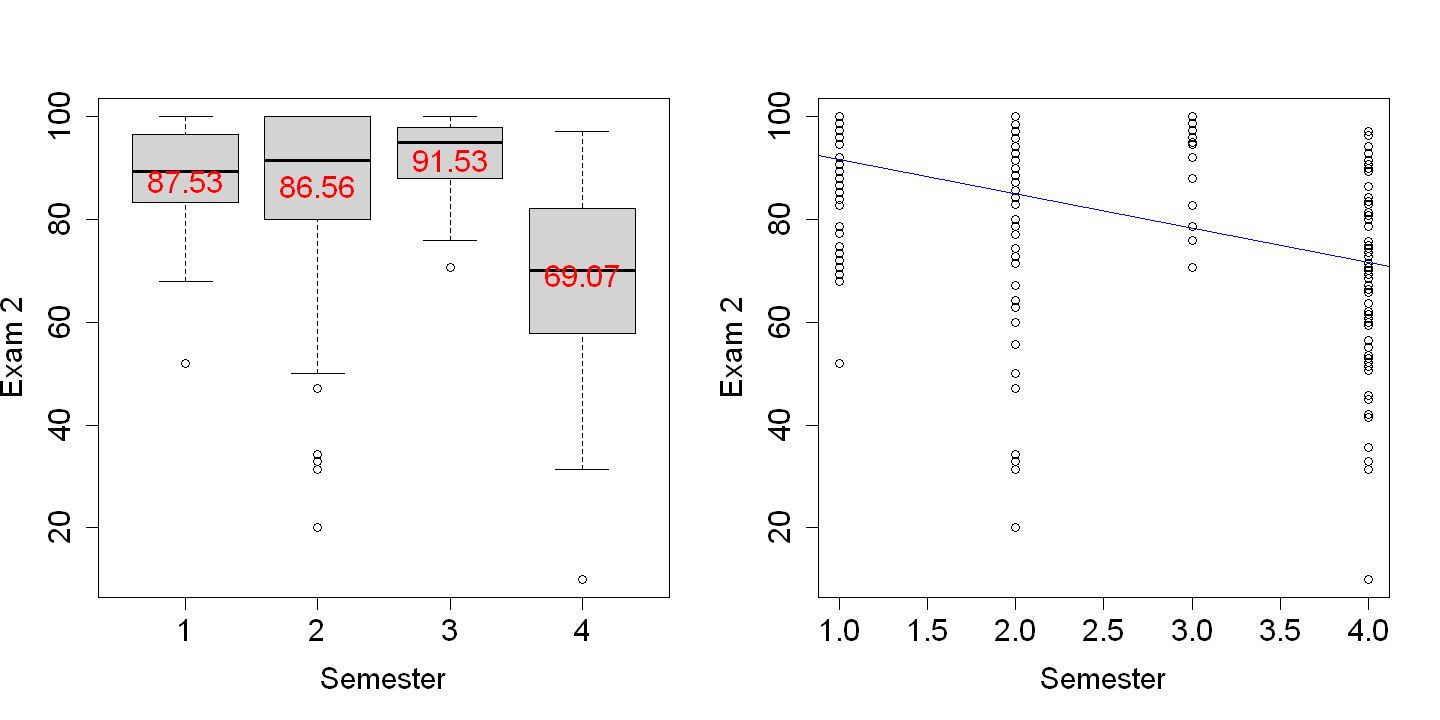

In [5]:
means = aggregate(exam2 ~  semester, data , mean)
par(mfrow = c(1,2))
options(repr.plot.width=12, repr.plot.height=6)
boxplot(data$exam2 ~ data$semester, xlab = "Semester", ylab = "Exam 2",cex.lab=1.5, cex.axis = 1.5)
text(1:4, means$exam2 + 0.06, labels = round(means$exam2,2), col = "red", cex=1.5)
plot(round(data$semester,0),data$exam2, xlab = "Semester", ylab = "Exam 2",cex.lab=1.5, cex.axis = 1.5)
abline(lm(data$exam2 ~ data$semester), col="blue")

 From these plots, we conclude that even though **there’s not a clear trend of Exam 2 with Semester, the linear fit indicates a slight decrease on the mean scores.**

To get a more quantitative sense of the data, let's check the correlation coefficients of Exam 2 with respect to each of the variables shown on Figures 1 and 2.

In [6]:
cor(data$exam2, data)

exam2,exam1,project,cs,hw,participation,semester
1,0.3957304,0.3266639,0.3137312,0.5431223,0.2948781,-0.4229744


Let's also check the single linear regression coefficients.

In [7]:
c(cov(data$exam2,data))[2:7]/c(var(data$exam1),
                               var(data$project),
                               var(data$cs),
                               var(data$hw),
                               var(data$participation),
                               var(data$semester))

[1]  0.4703109  0.2338799  0.3472803  0.5491200  0.2826811 -6.6341516

**We conclude from this early analysis that the variables Exam 1, Homework and Semester Number are the ones with highest correlation with Exam 2.** This observation will be corroborated when the multiple linear regression models are compared.

---

### 3. Modeling with Multivariate Linear Models


In this section, we want to select a linear model that relates y and X. To do that, we start by including all predictors X
while checking the significance of each predictor separetely. We then exclude some of the predictors with low significance and re-fit the data for the reduced models. This is repeated until the best combination of predictors is found. **During this process, we use a significance level of 0.05; that is, we exclude a predictor if its regression coefficient has an associated p-value above 0.05.**

The first attempt is the multiple linear regression model taking into account all predictors, referred to as Model 1 or Full Model:

In [8]:
model1 = lm(exam2 ~ ., data = data)
summary(model1)


Call:
lm(formula = exam2 ~ ., data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-57.414  -6.793   0.850   7.831  27.124 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   35.26655    5.46283   6.456 5.03e-10 ***
exam1          0.34756    0.05853   5.939 8.88e-09 ***
project        0.01576    0.03971   0.397    0.692    
cs             0.02337    0.05811   0.402    0.688    
hw             0.40359    0.06267   6.440 5.49e-10 ***
participation -0.02741    0.05210  -0.526    0.599    
semester      -7.51155    0.66993 -11.212  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.06 on 268 degrees of freedom
Multiple R-squared:  0.5405,	Adjusted R-squared:  0.5302 
F-statistic: 52.54 on 6 and 268 DF,  p-value: < 2.2e-16


By looking at the last column in "Coefficients" table, **we conclude that the variables Project, Case Study and Participation are candidates for being dropped out from the model since the p-values of their coefficients are larger than 0.05**. We also note that the values of their coefficients are the much closer to 0 compared to the variables Exam 1, Homework and Semester.

From this observation, we next evaluate 4 different models:

- Model 2 - Full Model (FM) with Project (P) and Case Study (C) removed: FM – (P + C) 
- Model 3 - FM with Participation (Pa) and C removed: FM – (C + Pa)
- Model 4 - FM with P and Pa removed: FM – (P + Pa)
- Model 5 - FM with the three variables removed at the same time: FM – (P+C+Pa)


For each model, the next table displays the R^2 coefficient, residual sums of squares (RSS), and the AIC statistic. **We see that the model with highest R^2 and lowest AIC is the model with the three predictors removed, suggesting that it is the most appropriate (Model 5).** Shown in the Appendix of this Notebook, the summary of each of the Models 2-4 indicated that the variable which was kept relative to Model 5 should be removed according to the p-value associated to its coefficient. This further indicates that Model 5 is the most appropriate. 

||R^2|RSS|AIC|
|-|-|-|-|
|Model 1|0.5302|38962.8|2158.6|
|Model 2|0.5328|39035.9|2155.2|
|Model 3|0.5329 |39028.7|2155.1|
|Model 4|0.533 |39017.5|2155.4|
|Model 5|0.5342 |39065.4|2153.4|


The appendix also contains the code used to compute the R^2, RSS and AIC metrics for each model. Here, we only show the summary of the chosen best model (model 5):

In [9]:
model5 = lm(exam2 ~ exam1  + hw + semester, data = data)
summary(model5)


Call:
lm(formula = exam2 ~ exam1 + hw + semester, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-57.029  -7.070   0.881   7.921  28.145 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 36.02239    4.73371   7.610 4.56e-13 ***
exam1        0.34759    0.05717   6.080 4.08e-09 ***
hw           0.40989    0.04775   8.584 7.28e-16 ***
semester    -7.54042    0.66197 -11.391  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.01 on 271 degrees of freedom
Multiple R-squared:  0.5393,	Adjusted R-squared:  0.5342 
F-statistic: 105.7 on 3 and 271 DF,  p-value: < 2.2e-16


Next, we calculate the confidence intervals for each coefficient of Model 5 using their standard errors and a Bonferroni correction

In [10]:
qt(1-0.95/6,271)*4.733
qt(1-0.95/6,271)*0.057
qt(1-0.95/6,271)*0.662
qt(1-0.95/6,271)*0.047

[1] 4.748073

[1] 0.05718153

[1] 0.6641082

[1] 0.04714968

**To summarize,** the model that best fits the score of Exam 2 based on the other variables of the Course is

$$
Exam2 = \beta_0 + \beta_1{Exam1} + \beta_2{Homework} +\beta_3{Semester} 
$$

The value of the coefficients $\beta_0$-$\beta_3$ and their corresponding CI's and p-values are:

||$\beta_0$|$\beta_1$|$\beta_2$|$\beta_3$|
|-|-|-|-|-|
|Coefficient|36.02 ± 4.748|0.35 ± 0.057|0.41 ± 0.047|-7.54 ± 0.664|
|p-value|4e-13|4e-9|8e-16|2e-16|

---


## 4. Evaluation of the Final Model

To evaluate the quality of the fit of the final model, we qualitatively looked both at the residuals and the predictions of Model 5 versus the actual Exam 2 scores, shown in the next figure.


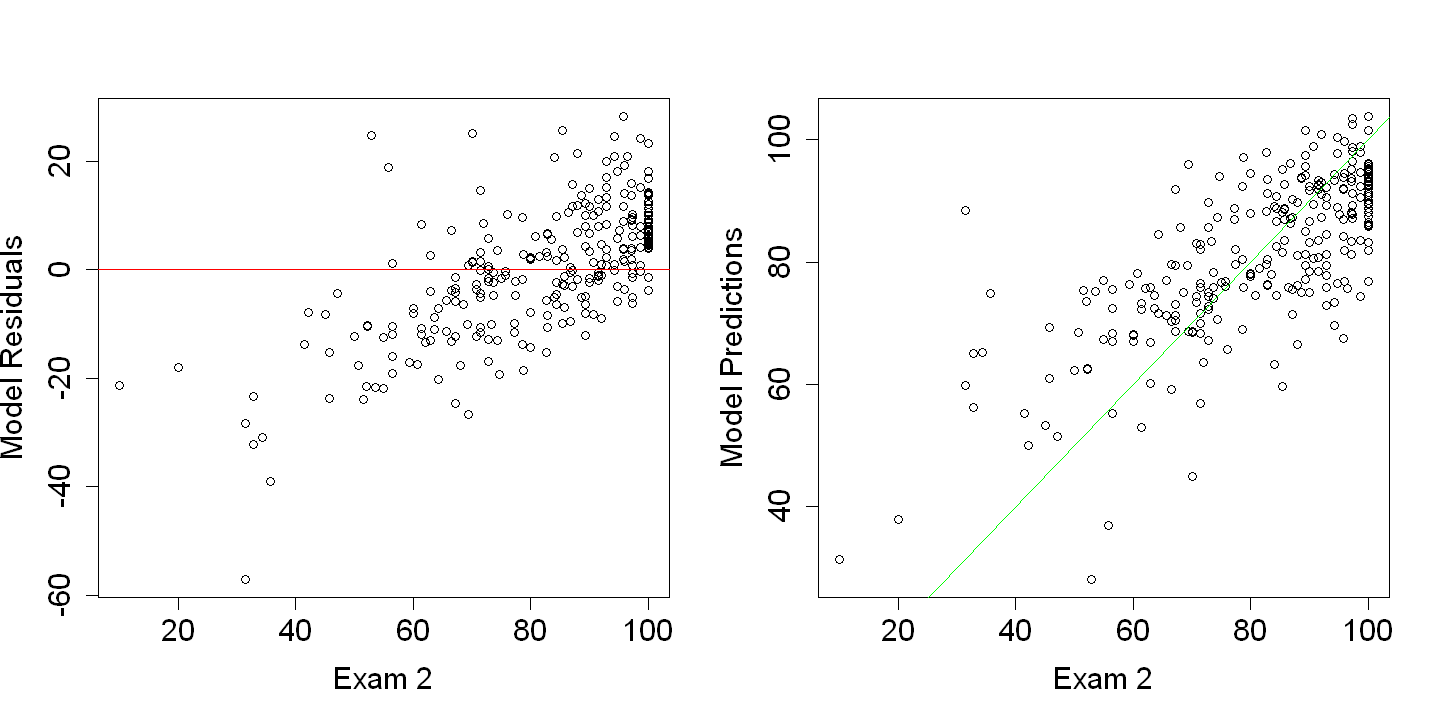

In [12]:
par(mfrow = c(1,2))
plot(data$exam2, residuals(model5), xlab = "Exam 2", ylab = "Model Residuals",cex.lab=1.5, cex.axis = 1.5)
abline(a=0, b=0, col="red")
plot(data$exam2, predict(model5), xlab = "Exam 2", ylab = "Model Predictions",cex.lab=1.5, cex.axis = 1.5)
abline(a=0, b=1, col="green")

As expected, the residuals are approximately uncorrelated to the Exam 2 scores and with a mean 0 (the line y = 0 is shown in red for comparison). In addition, the right plot shows that the predicted and actual values have a correlation near 1, as indicated by the y = x line shown in green.

Finally, the next figure shows a histogram of the residuals of the model. 

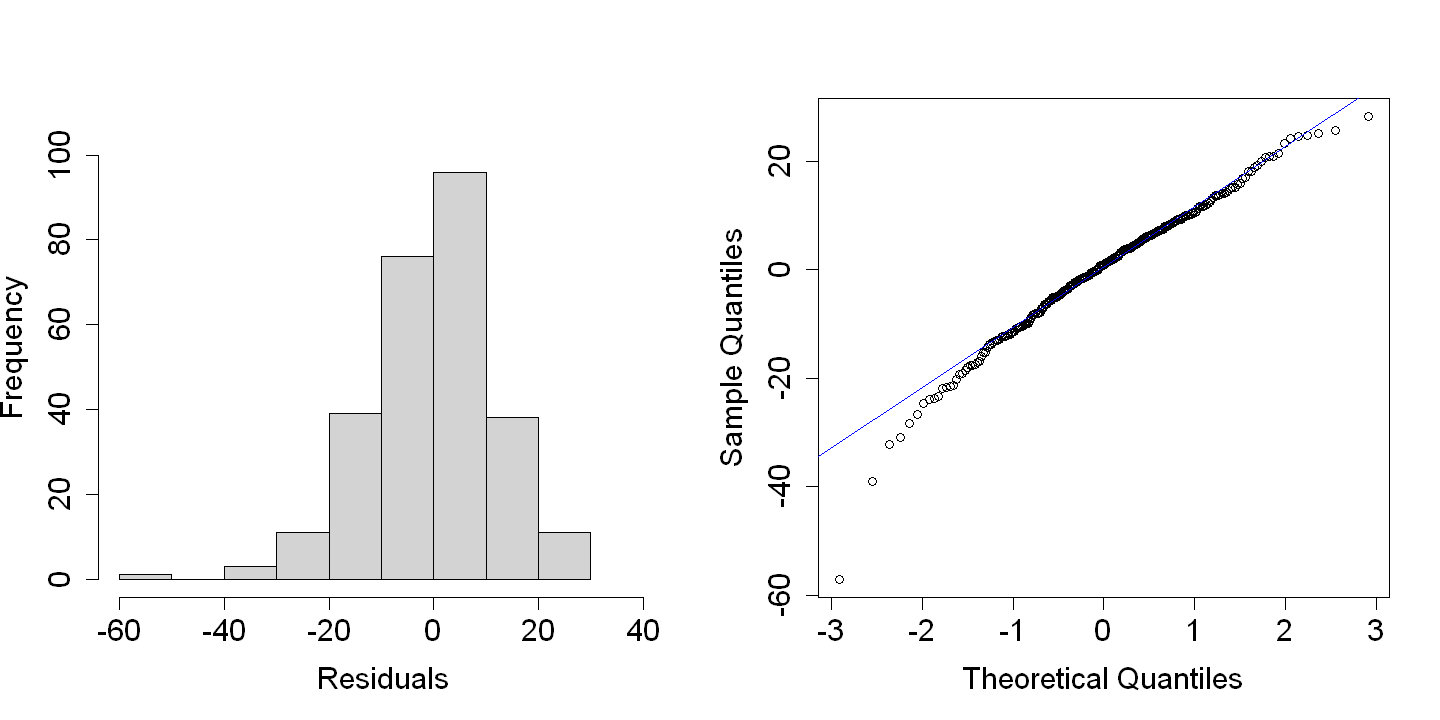

In [13]:
par(mfrow = c(1,2))
hist(residuals(model5), main = "", xlim = c(-60,41), ylim = c(0,109),xlab = "Residuals", cex.axis = 1.5, cex.lab = 1.5)
qqnorm(residuals(model5),main = "", cex.lab=1.5, cex.axis = 1.5)
qqline(residuals(model5), col = "blue")

The near-normal distribution of the residuals around 0 indicates that the assumptions behind the linear regression model are reasonable. Corroborating this, the right panel shows a quantile-quantile (QQ) plot of the residuals, together with a blue line indicating the approximately linear dependence of the theoretical quantiles given by a standard normal distribution and the sample residual quantiles. As shown in the QQ plot, deviation from the normality of the residuals is more pronounced near the edges of the data, where the residuals are larger than 20. This is most likely a result of the truncation of the Exam 2 scores at 100.

## 5. Conclusion

In conclusion, the analysis in this work shows that the expected grade of a student in their second exam can be predicted by knowing their grade in exam 1, their homework grade and in what semester they are taking the course. Students which perform well on exam 1 and their homework tend to perform better in exam 2. In addition, the model shows a small tendency for students to perform worse in the exam versus students in the previous semester.

## Appendix

Here, we show the summaries of Models 2-5 as well as the code for computing AIC and RSS for each model.

**Model 2: FM – (P + C)**

In [14]:
model2 = lm(exam2 ~ exam1 + participation  + hw + semester, data = data)
summary(model2)


Call:
lm(formula = exam2 ~ exam1 + participation + hw + semester, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-57.196  -6.745   0.929   7.815  27.045 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   36.43347    4.82698   7.548 6.81e-13 ***
exam1          0.35166    0.05796   6.067 4.38e-09 ***
participation -0.02318    0.05124  -0.452    0.651    
hw             0.42315    0.05609   7.545 6.96e-13 ***
semester      -7.50346    0.66796 -11.233  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.02 on 270 degrees of freedom
Multiple R-squared:  0.5396,	Adjusted R-squared:  0.5328 
F-statistic: 79.12 on 4 and 270 DF,  p-value: < 2.2e-16


---

**Model 3: FM – (C + Pa)**

In [15]:
model3 = lm(exam2 ~ exam1 + project  + hw + semester, data = data)
summary(model3)


Call:
lm(formula = exam2 ~ exam1 + project + hw + semester, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-57.050  -7.150   1.068   7.764  27.639 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 35.81709    4.75769   7.528 7.72e-13 ***
exam1        0.34554    0.05740   6.020 5.66e-09 ***
project      0.01834    0.03638   0.504    0.615    
hw           0.39575    0.05544   7.139 8.71e-12 ***
semester    -7.55314    0.66336 -11.386  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.02 on 270 degrees of freedom
Multiple R-squared:  0.5397,	Adjusted R-squared:  0.5329 
F-statistic: 79.15 on 4 and 270 DF,  p-value: < 2.2e-16


**Model 4: FM – (P + Pa)**

In [16]:
model4 = lm(exam2 ~ exam1 + cs  + hw + semester, data = data)
summary(model4)


Call:
lm(formula = exam2 ~ exam1 + cs + hw + semester, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-57.256  -6.846   0.801   7.691  27.903 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 34.60617    5.33947   6.481 4.30e-10 ***
exam1        0.34350    0.05768   5.955 8.07e-09 ***
cs           0.03106    0.05393   0.576    0.565    
hw           0.39684    0.05292   7.499 9.26e-13 ***
semester    -7.54563    0.66285 -11.384  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.02 on 270 degrees of freedom
Multiple R-squared:  0.5398,	Adjusted R-squared:  0.533 
F-statistic: 79.19 on 4 and 270 DF,  p-value: < 2.2e-16


**Model 5: FM – (P+C+Pa)**

In [17]:
model5 = lm(exam2 ~ exam1  + hw + semester, data = data)
summary(model5)


Call:
lm(formula = exam2 ~ exam1 + hw + semester, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-57.029  -7.070   0.881   7.921  28.145 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 36.02239    4.73371   7.610 4.56e-13 ***
exam1        0.34759    0.05717   6.080 4.08e-09 ***
hw           0.40989    0.04775   8.584 7.28e-16 ***
semester    -7.54042    0.66197 -11.391  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.01 on 271 degrees of freedom
Multiple R-squared:  0.5393,	Adjusted R-squared:  0.5342 
F-statistic: 105.7 on 3 and 271 DF,  p-value: < 2.2e-16


AIC for each model

In [18]:
cat("Model 1 AIC", AIC(model1), "\n")
cat("Model 2 AIC", AIC(model2), "\n")
cat("Model 3 AIC", AIC(model3), "\n")
cat("Model 4 AIC", AIC(model4), "\n")
cat("Model 5 AIC", AIC(model5), "\n")

Model 1 AIC 2158.654 
Model 2 AIC 2155.169 
Model 3 AIC 2155.119 
Model 4 AIC 2155.04 
Model 5 AIC 2153.377 


RSS of each model:

In [19]:
cat("Model 1 RSS", sum(residuals(model1)^2), "\n")
cat("Model 2 RSS", sum(residuals(model2)^2), "\n")
cat("Model 3 RSS", sum(residuals(model3)^2), "\n")
cat("Model 4 RSS", sum(residuals(model4)^2), "\n")
cat("Model 5 RSS", sum(residuals(model5)^2), "\n")

Model 1 RSS 38962.81 
Model 2 RSS 39035.86 
Model 3 RSS 39028.7 
Model 4 RSS 39017.51 
Model 5 RSS 39065.45 


```
